In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import os
from collections import OrderedDict

In [82]:
path = '/home/kernfel/Documents/Data/RTDO/Kv14x_fixed/sessions/2019.06.18-15.56.02/'
index_file = 'full.index'
modelname = 'Kv1.4x'
figfile_basename = 'figure_%g' # %g for group names
percentile = 25
grid_width = 2
grid_height = 3
grid_size = (15,10)
figsize = (10,5)
boxplot_epochs = (100,250,500)
reference_epoch = 500
save_figures = True

In [3]:
os.chdir(path)

In [4]:
# Load index
with open(index_file) as ifile:
    index = [row for row in csv.DictReader(ifile, delimiter = '\t')]

In [5]:
gnames_raw = []
for row in index:
    if row['group'] not in gnames_raw:
        gnames_raw.append(row['group'])
print gnames_raw

['DE, cluster, graded', 'DE, bubble, graded', 'DE, cluster, unweighted', 'DE, bubble, unweighted', 'DE, cluster, target-only', 'DE, bubble, target-only', 'xGA, cluster, graded', 'xGA, bubble, graded', 'xGA, cluster, unweighted', 'xGA, bubble, unweighted', 'xGA, cluster, target-only', 'xGA, bubble, target-only', 'mGA, cluster, graded', 'mGA, bubble, graded', 'mGA, cluster, unweighted', 'mGA, bubble, unweighted', 'mGA, cluster, target-only', 'mGA, bubble, target-only']


In [6]:
group_mapping = OrderedDict()

def map_groups(fragments):
    for fragment in fragments:
        group_mapping[fragment] = [g for g in gnames_raw if fragment in g]

In [7]:
# raw:
# for g in gnames_raw:
#     group_mapping[g] = g

# By fitting method, pooled:
map_groups(['DE', 'xGA', 'mGA'])

In [8]:
gnames = group_mapping.keys()
def index_by_group(gname, rows=index):
    for row in rows:
        if row['group'] in group_mapping[gname]:
            yield row

print [(gname, len([r for r in index_by_group(gname)])) for gname in gnames]

[('DE', 35), ('xGA', 35), ('mGA', 35)]


In [9]:
n_cells = 0
cnames = []
for row in index:
    if row['cell'] not in cnames:
        cnames.append(row['cell'])
        n_cells += 1
print cnames

def index_by_cell(cell, rows=index):
    for row in rows:
        if row['cell'] == cell:
            yield row

['Kv14-20', 'Kv14-21', 'Kv14-22', 'Kv14-23', 'Kv14-24', 'Kv14-25', 'Kv14-26', 'Kv14-27']


In [10]:
# Load param names and deltabar-normalised sigmata
with open('../../paramnames') as pfile:
    pnames, sigmata = zip(*[(row[0], float(row[1])) for row in csv.reader(pfile, delimiter = '\t')])
    with open('../../deltabar') as dfile:
        deltabar = [float(row[0]) for row in csv.reader(dfile)]
    sigmata = np.divide(sigmata, deltabar)
print pnames
print sigmata
nparams = len(pnames)

('gA_slow', 'gA_fast', 'EK', 'gl', 'El', 'C')
[0.0704399  0.14814376 0.09430226 0.01862132 0.21647458 1.60699622]


In [21]:
# Load target parameter values
for row in index:
    row['reference'] = np.zeros(nparams)
    with open(row['record'].replace('.atf', '.params')) as tfile:
        for trow in csv.reader(tfile, delimiter='\t'):
            try:
                idx = pnames.index(trow[0].split(':')[0])
                row['reference'][idx] = float(trow[1].split(' ')[0])
            except:
                ;

In [22]:
# Load populations
for row in index:
    row['n_epochs'] = int(row['n_epochs'])
    row['n_pop'] = int(row['n_pop'])
    row['n_subpops'] = int(row['n_subpops'])
    row['subpop_sz'] = row['n_pop'] // row['n_subpops']
    with open('%04d.GAFitter.fit.pops' % int(row['fileno'])) as datafile:
        row['data'] = np.fromfile(datafile, dtype=np.dtype(np.float32)).reshape(
            (row['n_epochs'], nparams, row['n_subpops'], row['subpop_sz']))

In [23]:
# Load step sizes
for row in index:
    with open('%04d.GAFitter.fit.steps' % int(row['fileno'])) as datafile:
        # steptype: (params)
        # steps: (n_subpops, params, epochs)
        row['steptype'] = np.fromfile(datafile, dtype=np.dtype(np.int8), count = nparams)
        if np.any(row['steptype'] > 1):
            assert np.all(row['steptype'] == row['n_subpops']), "DE multipopulation step type must equal n_subpops."
            row['steps'] = np.fromfile(datafile, dtype=np.dtype(np.float32)).reshape(
                (row['n_subpops'], nparams, row['n_epochs']))
        else:
            steps = np.fromfile(datafile, dtype=np.dtype(np.float32)).reshape((nparams, row['n_epochs']))
            row['steps'] = np.array([steps] * row['n_subpops'])

In [24]:
for gname in gnames:
    group = [row for row in index_by_group(gname)]
    print gname
    for cname in cnames:
        print [(row['fileno'], row['cell']) for row in index_by_cell(cname, group)]

DE
[('7', 'Kv14-20'), ('17', 'Kv14-20'), ('24', 'Kv14-20'), ('33', 'Kv14-20'), ('40', 'Kv14-20'), ('47', 'Kv14-20')]
[('8', 'Kv14-21'), ('25', 'Kv14-21')]
[('9', 'Kv14-22'), ('26', 'Kv14-22')]
[('10', 'Kv14-23'), ('18', 'Kv14-23'), ('27', 'Kv14-23'), ('34', 'Kv14-23'), ('41', 'Kv14-23'), ('48', 'Kv14-23')]
[('11', 'Kv14-24'), ('19', 'Kv14-24'), ('28', 'Kv14-24'), ('35', 'Kv14-24'), ('42', 'Kv14-24'), ('49', 'Kv14-24')]
[('13', 'Kv14-25'), ('21', 'Kv14-25'), ('30', 'Kv14-25'), ('37', 'Kv14-25'), ('44', 'Kv14-25'), ('51', 'Kv14-25')]
[('14', 'Kv14-26'), ('22', 'Kv14-26'), ('31', 'Kv14-26'), ('38', 'Kv14-26'), ('45', 'Kv14-26'), ('52', 'Kv14-26')]
[('16', 'Kv14-27')]
xGA
[('54', 'Kv14-20'), ('64', 'Kv14-20'), ('71', 'Kv14-20'), ('80', 'Kv14-20'), ('87', 'Kv14-20'), ('94', 'Kv14-20')]
[('55', 'Kv14-21'), ('72', 'Kv14-21')]
[('56', 'Kv14-22'), ('73', 'Kv14-22')]
[('57', 'Kv14-23'), ('65', 'Kv14-23'), ('74', 'Kv14-23'), ('81', 'Kv14-23'), ('88', 'Kv14-23'), ('95', 'Kv14-23')]
[('58', 'Kv14-2

In [29]:
def plot_single_shaded(ax, triplet):
    baseline, = ax.plot(triplet[1,:])
    color = baseline.get_color()
    ax.fill_between(range(len(triplet[0,:])), triplet[0,:], triplet[2,:],
                    facecolor=color+'55', edgecolor=color+'99')
    return baseline

def plot_with_shade(axes, triplet):
    for i,ax in enumerate(axes.ravel()):
        if i < nparams:
            baseline = plot_single_shaded(ax, triplet[:,:,i])
    return baseline

In [67]:
def fig_setup(xlabel = '', ylabel = ''):
    fig,ax = plt.subplots(figsize=figsize)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    return fig,ax

def grid_setup(**kwargs):
    fig,axes = plt.subplots(grid_height, grid_width, sharex='col', figsize=grid_size)
    for i,ax in enumerate(axes.ravel()):
        if i < nparams:
            ax.set_ylabel(kwargs.get('param_prefix','') + pnames[i] + kwargs.get('param_suffix', ''))
            if i >= nparams - grid_width:
                ax.set_xlabel('Epoch')
    return fig,axes

In [27]:
def figname(name, fmt = 'svg'):
    return figfile_basename.replace('%g', '-'.join(gnames)) + '_' + name + '.' + fmt

## Raw convergence

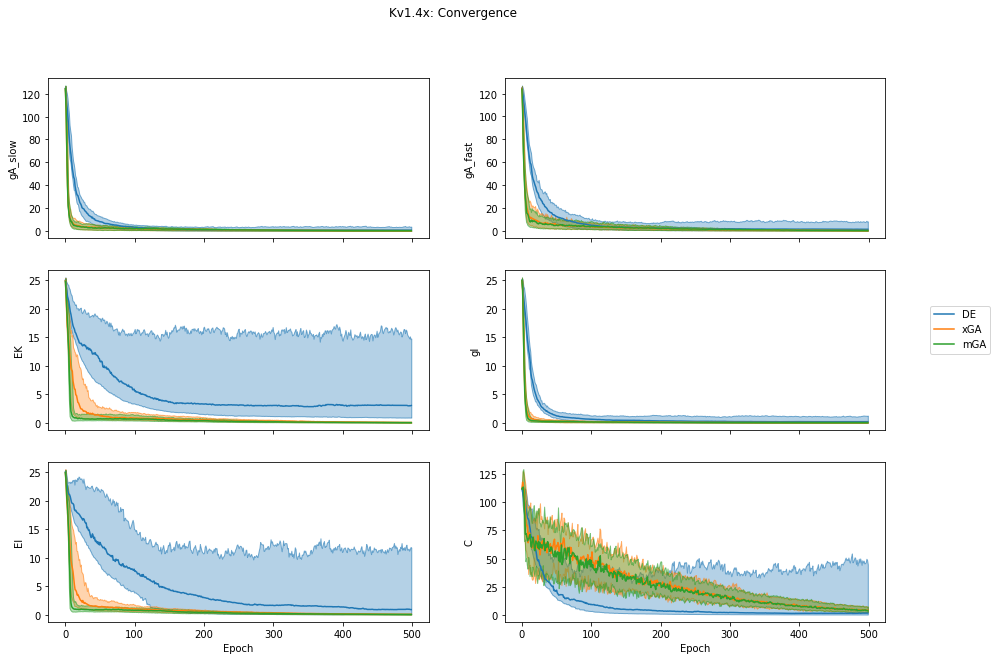

In [30]:
fig,ax = grid_setup()
lines = []
for gname in gnames:
    rows = index_by_group(gname)
    # data: (epochs, params, subpops, subpop_sz)
    # mads: (fits, epochs, params, subpops)
    # convergence: (epochs, params)
    mads = [np.median(np.abs(row['data'] - np.median(row['data'], axis=3)[:,:,:,None]), axis=3) for row in rows]
    if len(mads) == 0:
        continue
    convergence = np.percentile(mads, [100-percentile, 50, percentile], axis=(0,3))
    lines.append(plot_with_shade(ax, convergence))
plt.figlegend(lines, gnames, 'center right')
plt.suptitle(modelname + ': Convergence')
if save_figures:
    plt.savefig(figname('convergence'))

## Internal consistency of convergence

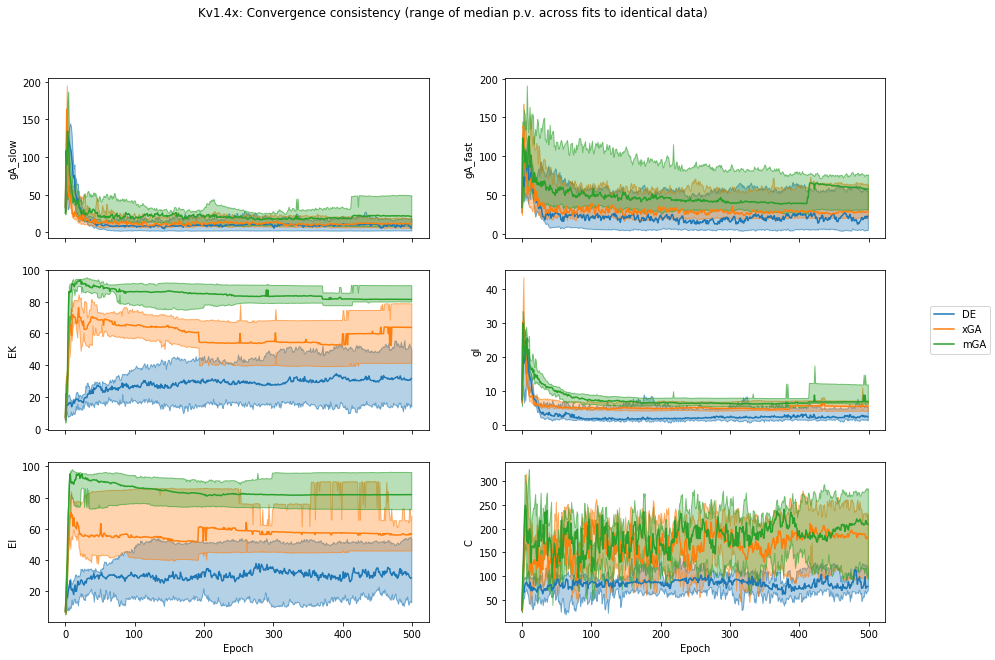

In [61]:
fig,ax = grid_setup()
lines = []
for gname in gnames:
    group = [row for row in index_by_group(gname)]
    group_ranges = []
    for cname in cnames:
        rows = index_by_cell(cname, group)
        # data: (epochs, params, subpops, subpop_sz)
        medians = [np.median(row['data'], axis=3) for row in rows] # (fits, epochs, params, subpops)
        if len(medians) == 0:
            continue
        ranges = np.max(medians, axis=(0,3)) - np.min(medians, axis=(0,3)) # (epochs, params)
        group_ranges.append(ranges) # (cells, epochs, params)
    consistency = np.percentile(group_ranges, [100-percentile, 50, percentile], axis=0)
    lines.append(plot_with_shade(ax, consistency))
plt.figlegend(lines, gnames, 'center right')
plt.suptitle(modelname + ': Convergence consistency (range of median p.v. across fits to identical data)')
if save_figures:
    plt.savefig(figname('consistency'))

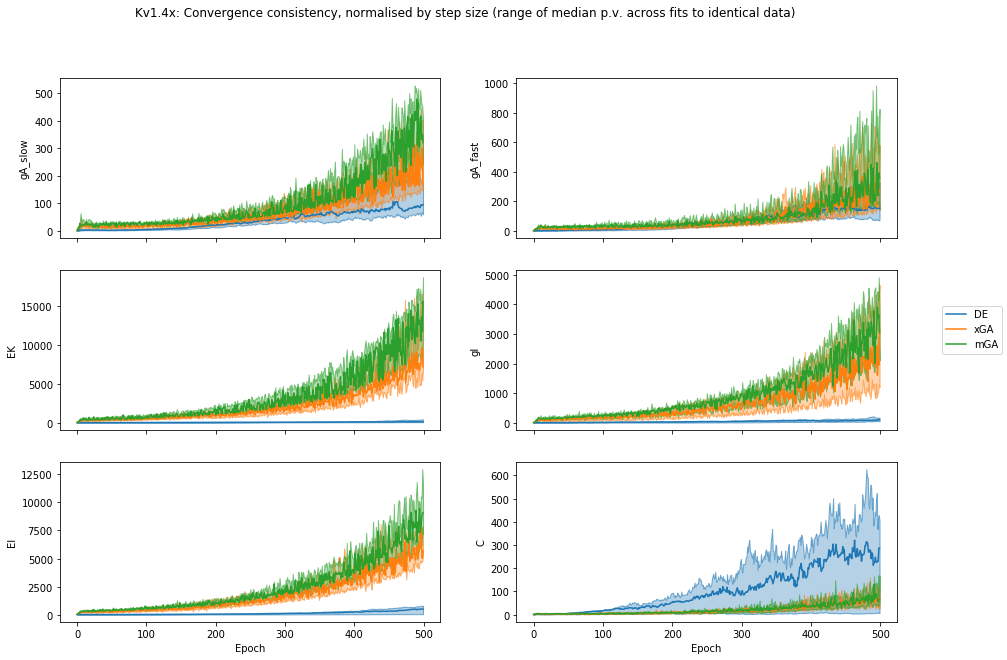

In [62]:
fig,ax = grid_setup()
lines = []
norm_consistency = []
for gname in gnames:
    group = [row for row in index_by_group(gname)]
    group_ranges = []
    for cname in cnames:
        rows = [row for row in index_by_cell(cname, group)]
        if len(rows) == 0:
            continue
        # data: (epochs, params, subpops, subpop_sz)
        # steps: (nparams, epochs)
        medians = [np.median(row['data'], axis=3) for row in rows] # (fits, epochs, params, subpops)
        med_step = np.median([row['steps'] for row in rows], axis=(0,1)) # (params, epochs)
        if np.any([row['steptype'] == 0 for row in rows]): # steptype==0 <=> multiplicative step size
            for row in rows:
                assert np.all((row['steptype']>0) == (rows[0]['steptype']>0)), \
                "Step type cannot differ within (group,cell) set."
            min_median, max_median = np.min(medians, axis=(0,3)).T, np.max(medians, axis=(0,3)).T # (params, epochs)
            mask = rows[0]['steptype'] == 0
            min_median[mask] = np.log(min_median[mask])
            max_median[mask] = np.log(max_median[mask])
            med_step[mask] = np.log(med_step[mask] + 1)
            ranges = (max_median - min_median) / med_step
            group_ranges.append(ranges.T) # (cells, epochs, params)
        else:
            ranges = np.max(medians, axis=(0,3)) - np.min(medians, axis=(0,3)) # (epochs, params)
            group_ranges.append(ranges / med_step.T) # (cells, epochs, params)
    consistency = np.percentile(group_ranges, [100-percentile, 50, percentile], axis=0)
    lines.append(plot_with_shade(ax, consistency))
    norm_consistency.append(np.array(group_ranges)) # (groups, cells, epochs, params)
plt.figlegend(lines, gnames, 'center right')
plt.suptitle(modelname + ': Convergence consistency, normalised by step size (range of median p.v. across fits to identical data)')
if save_figures:
    plt.savefig(figname('stepnorm-consistency'))

In [63]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def boxplot(data, group_names = gnames, param_names = pnames): # data: (groups, params, datapoints)
    numg, nump = len(group_names), len(param_names)

    for i, group in enumerate(data):
        line, = plt.plot([], label=group_names[i])
        col = line.get_color()
        b = plt.boxplot(group.T, positions=np.arange(i, (numg+1)*nump, (numg+1)),
                        widths=0.8, flierprops={'markeredgecolor':col})
        set_box_color(b, col)

    plt.xticks(np.arange((numg-1)/2., (numg+1)*nump, numg+1), param_names)
    plt.xlim(-1, (numg+1)*nump-1)
    plt.ylim(ymin=0)
    plt.legend()

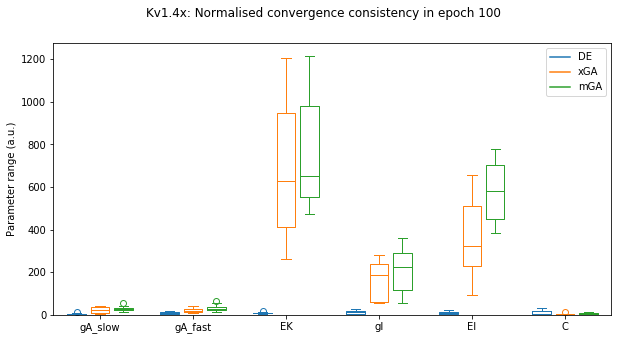

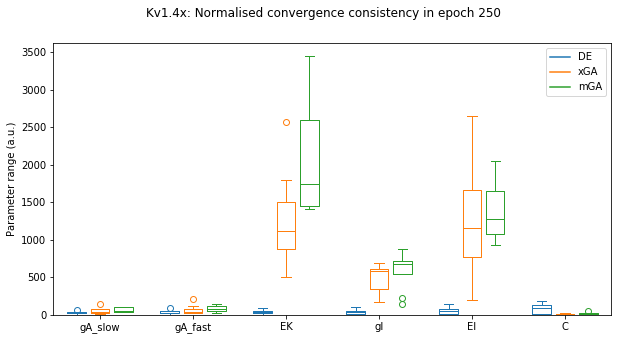

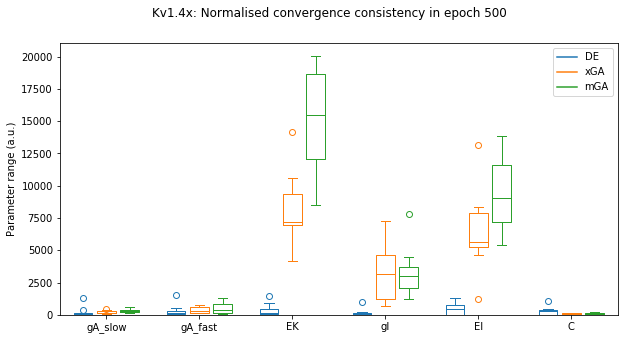

In [68]:
for epoch in boxplot_epochs:
    # norm_consistency: (groups, cells, epochs, params)
    fig_setup(ylabel = 'Parameter range (a.u.)')
    boxplot([cons[:,epoch-1,:].T for cons in norm_consistency], gnames, pnames)
    plt.suptitle(modelname + ': Normalised convergence consistency in epoch %d' % epoch)
    if save_figures:
        plt.savefig(figname('stepnorm-consistency-box-ep%d' % epoch))

## Internal consistency without splitting by parameter

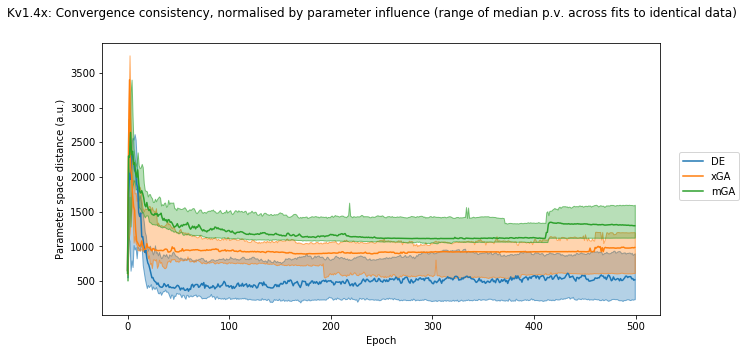

In [65]:
fig,ax = fig_setup(xlabel='Epoch', ylabel='Parameter space distance (a.u.)')
lines = []
signorm_consistency = []
for gname in gnames:
    group = [row for row in index_by_group(gname)]
    group_ranges = []
    for cname in cnames:
        rows = [row for row in index_by_cell(cname, group)]
        if len(rows) == 0:
            continue
        # data: (epochs, params, subpops, subpop_sz)
        # sigmata: (nparams,)
        medians = [np.median(row['data'], axis=3) for row in rows] # (fits, epochs, params, subpops)
        ranges = np.max(medians, axis=(0,3)) - np.min(medians, axis=(0,3)) # (epochs, params)
        group_ranges.append(np.linalg.norm(ranges / sigmata, axis=1)) # (cells, epochs)
    consistency = np.percentile(group_ranges, [100-percentile, 50, percentile], axis=0)
    lines.append(plot_single_shaded(ax, consistency))
    signorm_consistency.append(np.array(group_ranges)) # (groups, cells, epochs)
plt.figlegend(lines, gnames, 'center right')
plt.suptitle(modelname + ': Convergence consistency, normalised by parameter influence (range of median p.v. across fits to identical data)')
if save_figures:
    plt.savefig(figname('signorm-consistency'))

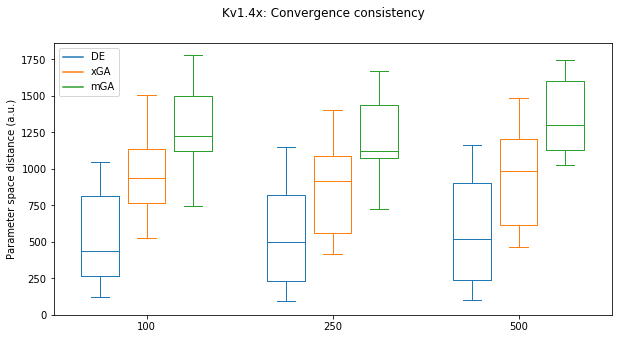

In [69]:
# signorm_consistency: (groups, cells, epochs)
fig_setup(ylabel='Parameter space distance (a.u.)')
boxplot([cons[:,np.array(boxplot_epochs)-1].T for cons in signorm_consistency], gnames, boxplot_epochs)
plt.suptitle(modelname + ': Convergence consistency')
if save_figures:
    plt.savefig(figname('signorm-consistency-box'))

## Convergence with reference parameter values

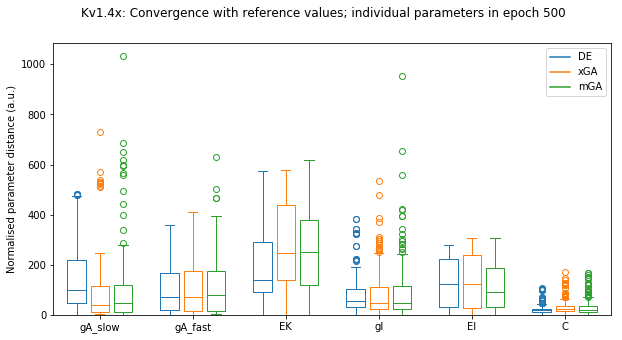

In [78]:
fig_setup(ylabel='Normalised parameter distance (a.u.)')
deviations_from_ref = []
for gname in gnames:
    group = [row for row in index_by_group(gname)]
    group_deviations = np.zeros((nparams,0))
    for cname in cnames:
        rows = [row for row in index_by_cell(cname, group)]
        if len(rows) == 0:
            continue
        # data: (epochs, params, subpops, subpop_sz)
        medians = [np.median(row['data'][reference_epoch-1,:,:,:], axis=2).T for row in rows] # (fits, subpops, params)
        references = np.array([row['reference'] for row in rows]) # (fits, params)
        deviations = np.subtract(medians, references[:,None,:]).reshape(-1, nparams).T # (params, *)
        group_deviations = np.append(group_deviations, np.abs(deviations) / sigmata[:,None], axis=1) # (params, *)
    deviations_from_ref.append(group_deviations) # (groups, params, *)
boxplot(deviations_from_ref)
plt.suptitle(modelname + ': Convergence with reference values; individual parameters in epoch %d' % reference_epoch)
if save_figures:
    plt.savefig(figname('convergence-with-reference-params'))

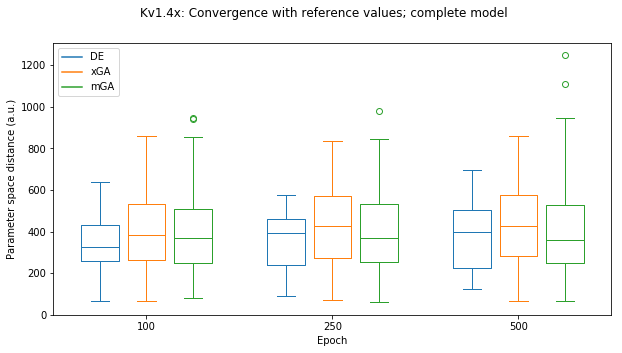

In [83]:
fig_setup(xlabel='Epoch', ylabel='Parameter space distance (a.u.)')
distances_to_ref = []
for gname in gnames:
    group = [row for row in index_by_group(gname)]
    group_distances = np.zeros((len(boxplot_epochs), 0))
    for cname in cnames:
        rows = [row for row in index_by_cell(cname, group)]
        if len(rows) == 0:
            continue
        # data: (epochs, params, subpops, subpop_sz)
        # np.median: (boxepochs, params, subpops)
        # medians: (fits, subpops, params, boxepochs)
        medians = [np.median(row['data'][np.array(boxplot_epochs)-1,:,:,:], axis=3).T for row in rows]
        references = np.array([row['reference'] for row in rows]) # (fits, params)
        deviations = np.subtract(medians, references[:,None,:,None]).reshape(-1, nparams, len(boxplot_epochs)) # (*, params, boxepochs)
        distances = np.linalg.norm(deviations / sigmata[None,:,None], axis=1).T # (boxepochs, *)
        group_distances = np.append(group_distances, distances, axis=1) # (boxepochs, *)
    distances_to_ref.append(group_distances) # (groups, boxepochs, *)
boxplot(distances_to_ref, param_names = boxplot_epochs)
plt.suptitle(modelname + ': Convergence with reference values; complete model')
if save_figures:
    plt.savefig(figname('convergence-with-reference-model'))